### Summary:

### Batch command used to generate embeddings:

```
python scripts/extract.py esm2_t33_650M_UR50D data/<sequences>.fasta output/<sequences>_reprs --repr_layers 0 32 33 --include mean per_tok
```


In [3]:
import torch
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import seaborn as sns
import esm

/stor/home/amh7958/miniconda3/envs/efficient-evolution/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import scipy
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import svm

### Add path to embeddings here:


In [5]:
ss_FASTA_PATH = "../data/rnap-phage-interpro-annotated-v1.fasta.txt"
b_FASTA_PATH = "../data/uniprotkb_accession_A0QS66_OR_accession_2024_03_03-subunit-beta.fasta"
ss_EMB_PATH = "../output/rnap_phage_interpro_v1_reprs"
b_EMB_PATH = "../output/uniprot_subunit_beta_03_03_reprs"
other_EMB_PATH = "../output/e_coli_NOT_ec_2_7_7_6_reprs"
other_FASTA_PATH = "../data/uniprotkb_e_coli_NOT_ec_2_7_7_6_AND_rev_2024_03_06.fasta"
EMB_LAYER = 33

In [30]:
ss_embs, ss_headers = ([], [])
for header, _seq in esm.data.read_fasta(ss_FASTA_PATH):
    fn = f'{ss_EMB_PATH}/{header}.pt' # path to ESM output, per sequence
    emb = torch.load(fn)
    reprs = emb['mean_representations'][EMB_LAYER]
    ss_embs.append(reprs)
    ss_headers.append(header)
Xs_ss = torch.stack(ss_embs, dim=0).numpy()

b_embs, b_headers = ([], [])
for header, _seq in esm.data.read_fasta(b_FASTA_PATH):
    fn = f'{b_EMB_PATH}/{header}.pt' # path to ESM output, per sequence
    emb = torch.load(fn)
    reprs = emb['mean_representations'][EMB_LAYER]
    b_embs.append(reprs)
    b_headers.append(header)
Xs_b = torch.stack(b_embs, dim=0).numpy()

other_embs, other_headers = ([], [])
for header, _seq in esm.data.read_fasta(other_FASTA_PATH):
    fn = f'{other_EMB_PATH}/{header}.pt' # path to ESM output, per sequence
    emb = torch.load(fn)
    reprs = emb['mean_representations'][EMB_LAYER]
    other_embs.append(reprs)
    other_headers.append(header)
Xs_other = torch.stack(other_embs, dim=0).numpy()

In [31]:
FASTA_PATH = "../data/uniprotkb_2024_02_15.fasta"
EMB_PATH = "../output/uniprot_2024_02_15_reprs"
embs, headers = ([], [])
for header, _seq in esm.data.read_fasta(FASTA_PATH):
    fn = f'{EMB_PATH}/{header}.pt' # path to ESM output, per sequence
    emb = torch.load(fn)
    reprs = emb['mean_representations'][EMB_LAYER].numpy()
    embs.append(reprs)
    headers.append(header)

T7_RNAP_emb = embs[3]

In [32]:
df1 = pd.DataFrame()
distances_ss = cosine_similarity(T7_RNAP_emb.reshape(1, -1), Xs_ss)
df1["ID"] = ss_headers
df1["distance"] = distances_ss.reshape(-1, 1)
df1["distance"] = 1 - df1["distance"]
df1["type"] = "ssRNAP"

df2 = pd.DataFrame()
distances_b = cosine_similarity(T7_RNAP_emb.reshape(1, -1), Xs_b)
df2["ID"] = b_headers
df2["distance"] = distances_b.reshape(-1, 1)
df2["distance"] = 1 - df2["distance"]
df2["type"] = "RNAP subunit beta/beta'"

df3 = pd.DataFrame()
distances_other = cosine_similarity(T7_RNAP_emb.reshape(1, -1), Xs_other)
df3["ID"] = other_headers
df3["distance"] = distances_other.reshape(-1, 1)
df3["distance"] = 1 - df3["distance"]
df3["type"] = "other"

In [33]:
df = pd.concat([df1, df2, df3])

Text(0.5, 0, '')

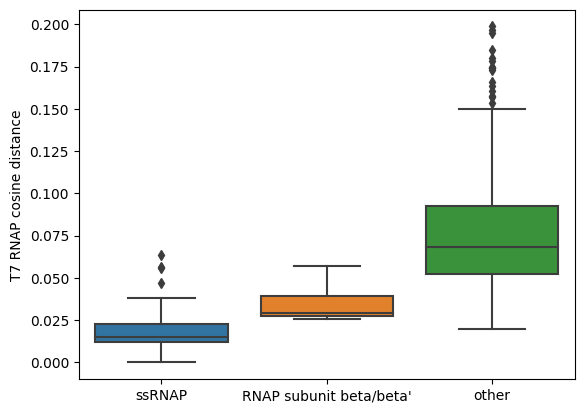

In [34]:
sns.boxplot(data=df[df.distance < 0.2], x="type", y="distance")
plt.ylabel("T7 RNAP cosine distance")
plt.xlabel("")

In [35]:
embs_all = np.concatenate((Xs_ss, Xs_b, Xs_other), axis=0)
embs_all.shape

(609, 1280)

In [36]:
num_pca_components = 20
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(embs_all)

Text(0, 0.5, 'PC2')

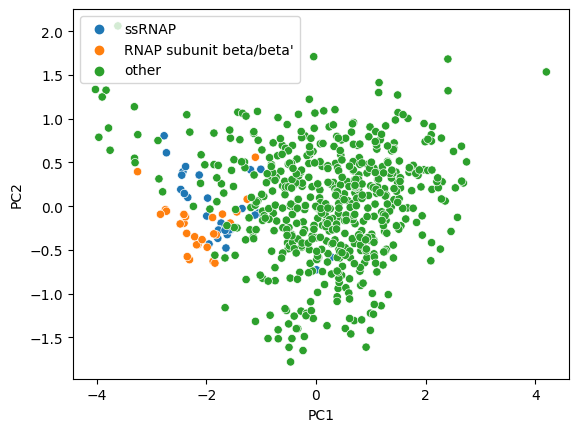

In [37]:
g = sns.scatterplot(x=Xs_train_pca[:,0], y=Xs_train_pca[:,1], hue=list(df["type"]))
plt.xlabel("PC1")
plt.ylabel("PC2")

<AxesSubplot: >

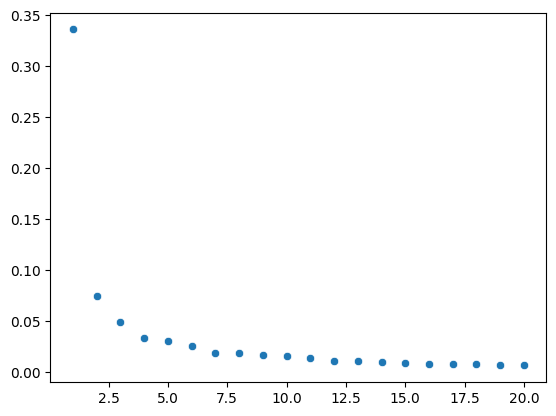

In [38]:
sns.scatterplot(x = [x for x in range(1, 21)], y = pca.explained_variance_ratio_)

In [39]:
df_master = pd.read_csv('phage_metagenomic_embeddings.csv', header=None)
df_master = df_master.rename(columns={0: "ID", 1: "desc"})
embeddings = df_master.iloc[:, 2:].to_numpy()
embeddings.shape

(117312, 1280)

In [40]:
Xs_test_pca = pca.transform(embeddings)

In [41]:
train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs_train_pca[:,:10], list(df["type"]), train_size=train_size, random_state=42)

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(Xs_train, ys_train)

RandomForestClassifier()

In [42]:
clf.score(Xs_test, ys_test)

0.9918032786885246

In [43]:
pred = clf.predict(Xs_test_pca[:,:10])
df_master["predictions"] = list(pred)
df_master["prob"] = list(clf.predict_proba(Xs_test_pca[:,:10]))
df_master["beta_prob"] = [probas[0] for probas in df_master["prob"]]
df_master["other_prob"] = [probas[1] for probas in df_master["prob"]]
df_master["ssRNAP_prob"] = [probas[2] for probas in df_master["prob"]]

In [49]:
print(df_master[(df_master.predictions == "other")][["ID", "desc", "prob", "ssRNAP_prob"]].sort_values("ssRNAP_prob", ascending=False).iloc[:100].to_string())

                 ID                                                                desc                prob  ssRNAP_prob
67772   DAN93655.1                    MAG TPA: hypothetical protein [Bacteriophage sp.]     [0.0, 0.5, 0.5]         0.50
25976   DAX08165.1                    MAG TPA: hypothetical protein [Bacteriophage sp.]     [0.0, 0.5, 0.5]         0.50
10113   DAW65884.1                    MAG TPA: hypothetical protein [Bacteriophage sp.]     [0.0, 0.5, 0.5]         0.50
82808   DAQ02145.1                    MAG TPA: hypothetical protein [Bacteriophage sp.]     [0.0, 0.5, 0.5]         0.50
24356   DAX05458.1                    MAG TPA: hypothetical protein [Bacteriophage sp.]     [0.0, 0.5, 0.5]         0.50
42299   DAS25445.1                    MAG TPA: hypothetical protein [Bacteriophage sp.]     [0.0, 0.5, 0.5]         0.50
92560   DAR45704.1      MAG TPA: Stage V sporulation protein family [Bacteriophage sp.]     [0.0, 0.5, 0.5]         0.50
72927   DAO48077.1              

In [23]:
ss_RNAP_pred = df_master[(df_master.predictions == "ssRNAP")]
ss_RNAP_pred_embeddings = ss_RNAP_pred.iloc[:,2:-1].to_numpy()
ss_RNAP_pred_embeddings.shape
ss_RNAP_pred

(71, 1281)

In [173]:
grid_search = [0.0001*x for x in range(1, 300, 5)] # for cosine
result = []
cov = []
for param in grid_search:
    groups = DBSCAN(eps=param, min_samples=3, metric="cosine").fit(ss_RNAP_pred_embeddings).labels_
    result.append(len(set(groups)))
    cov.append(1 - (list(groups).count(-1)/105))

Text(0.5, 0, 'epsilon')

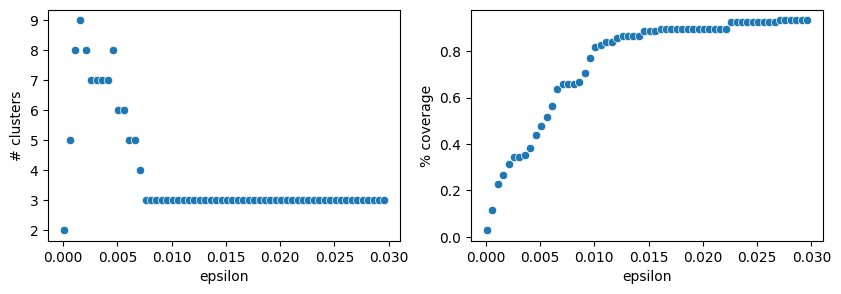

In [174]:
rcParams['figure.figsize'] = [10, 3]
fig, ax = plt.subplots(1,2)
sns.scatterplot(x=grid_search, y=result, ax=ax[0])
sns.scatterplot(x=grid_search, y=cov, ax=ax[1])
ax[0].set_ylabel("# clusters")
ax[1].set_ylabel("% coverage")
ax[0].set_xlabel("epsilon")
ax[1].set_xlabel("epsilon")

In [175]:
clustering = DBSCAN(eps=0.005, min_samples=3, metric="cosine").fit(ss_RNAP_pred_embeddings)
ss_RNAP_pred["DBSCAN"] = clustering.labels_.tolist()

/tmp/ipykernel_868976/3820618359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss_RNAP_pred["DBSCAN"] = clustering.labels_.tolist()


In [176]:
ss_RNAP_pred[(ss_RNAP_pred.DBSCAN != -1)][["ID", "desc", "DBSCAN"]].sort_values("DBSCAN").to_csv("clusters.csv")

In [177]:
pred_f = ss_RNAP_pred[(ss_RNAP_pred.DBSCAN != -1)]
pred_f_emb = pred_f.iloc[:,2:-2].to_numpy()

In [178]:
num_pca_components = 20
pca = PCA(num_pca_components)
ss_pred_pca = pca.fit_transform(pred_f_emb)

/tmp/ipykernel_868976/1689859195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_f["DBSCAN"] = pred_f["DBSCAN"].astype(str)


Text(0, 0.5, 'PC2')

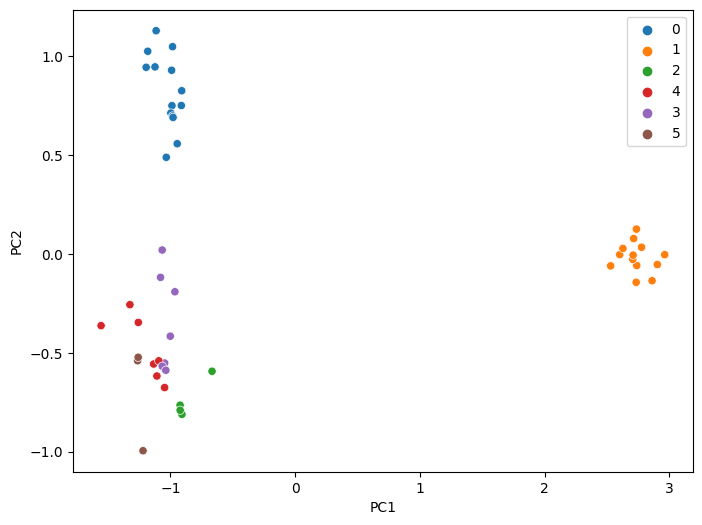

In [185]:
rcParams['figure.figsize'] = [8, 6]
pred_f["DBSCAN"] = pred_f["DBSCAN"].astype(str)

g = sns.scatterplot(x=ss_pred_pca[:,0], y=ss_pred_pca[:,1], hue=list(pred_f["DBSCAN"]))
plt.xlabel("PC1")
plt.ylabel("PC2")

In [160]:
print(ss_RNAP_pred[(ss_RNAP_pred.DBSCAN != -1)][["ID", "desc", "DBSCAN"]].sort_values("DBSCAN").to_string())

                 ID                                                      desc  DBSCAN
836     DAV41656.1          MAG TPA: hypothetical protein [Bacteriophage sp.]       0
64902   DAN56351.1          MAG TPA: hypothetical protein [Bacteriophage sp.]       0
64100   DAN44485.1          MAG TPA: hypothetical protein [Bacteriophage sp.]       0
10308   DAW66364.1          MAG TPA: hypothetical protein [Bacteriophage sp.]       0
46268   DAS88247.1          MAG TPA: hypothetical protein [Bacteriophage sp.]       0
34447   DAX80898.1          MAG TPA: hypothetical protein [Bacteriophage sp.]       0
37701   DAY36341.1          MAG TPA: hypothetical protein [Bacteriophage sp.]       0
43211   DAS41342.1          MAG TPA: hypothetical protein [Bacteriophage sp.]       0
80172   DAP29885.1          MAG TPA: hypothetical protein [Bacteriophage sp.]       1
64958   DAN56407.1          MAG TPA: hypothetical protein [Bacteriophage sp.]       1
56165   DAU28673.1          MAG TPA: hypothetical prot